In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 25.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostClassifier
from scipy.stats import norm

In [ ]:
# Функция для расчета Gini
def gini(y_true, y_predict):
    return 2 * roc_auc_score(y_true, y_predict) - 1

In [ ]:
data = pd.read_csv('diabetes_prediction_dataset.csv')
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [ ]:
# Handle duplicates
duplicate_rows_data = data[data.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)

number of duplicate rows:  (3854, 9)


In [ ]:
data = data.drop_duplicates()

In [ ]:
# Loop through each column and count the number of distinct values
for column in data.columns:
    num_distinct_values = len(data[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 3 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


In [ ]:
data.iloc[:,0].unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [ ]:
gender_d = {'Female':0, 'Male':1}
smoking_history_d = {'No Info':0, 'never':1, 'current':2, 'former':3, 'ever':4, 'not current':5}

In [ ]:
data = data[data['gender'] != 'Other']

In [ ]:
# Checking null values
print(data.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [ ]:
data_ = data.copy()

In [ ]:
data_['gender'] = data_['gender'].map(gender_d)
data_['smoking_history'] = data_['smoking_history'].map(smoking_history_d )

In [ ]:
data_.describe().style.format("{:.2f}")

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00
mean,0.42,41.80,0.08,0.04,1.34,27.32,5.53,138.22,0.09
std,0.49,22.46,0.27,0.20,1.46,6.77,1.07,40.91,0.28
min,0.00,0.08,0.00,0.00,0.00,10.01,3.50,80.00,0.00
25%,0.00,24.00,0.00,0.00,0.00,23.40,4.80,100.00,0.00
50%,0.00,43.00,0.00,0.00,1.00,27.32,5.80,140.00,0.00
75%,1.00,59.00,0.00,0.00,2.00,29.86,6.20,159.00,0.00
max,1.00,80.00,1.00,1.00,5.00,95.69,9.00,300.00,1.00


In [ ]:
data_.reset_index(drop=True, inplace=True)

In [ ]:
X = data_.drop('diabetes', axis=1)
y = data_['diabetes']

In [ ]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормализация данных для Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 1. Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

print("Random Forest:")
print("Accuracy: {:.4f} ± {:.4f}".format(rf_cv_scores.mean(), rf_cv_scores.std()))

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_proba = rf_model.predict_proba(X_test)[:, 1]

print("Gini:", gini(y_test, y_pred_rf_proba))
# print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest:
Accuracy: 0.9687 ± 0.0009
Gini: 0.9181977874892757


In [ ]:
# 2. Logistic Regression с нормализованными данными
logreg_model = LogisticRegression(max_iter=10000, random_state=42)
logreg_cv_scores = cross_val_score(logreg_model, scaler.fit_transform(X), y, cv=5, scoring='accuracy')

print("Logistic Regression (with normalization):")
print("Accuracy: {:.4f} ± {:.4f}".format(logreg_cv_scores.mean(), logreg_cv_scores.std()))

logreg_model = LogisticRegression(max_iter=10000, random_state=42)
logreg_model.fit(X_train_scaled, y_train)
y_pred_logreg = logreg_model.predict(X_test_scaled)
y_pred_logreg_proba = logreg_model.predict_proba(X_test_scaled)[:, 1]

print("Gini:", gini(y_test, y_pred_logreg_proba))
# print("Accuracy:", accuracy_score(y_test, y_pred_logreg))

Logistic Regression (with normalization):
Accuracy: 0.9588 ± 0.0005
Gini: 0.9166011434072932


In [ ]:
# 3. CatBoost с улучшенными параметрами
catboost_model = CatBoostClassifier(
    iterations=2000,         # Увеличение количества итераций
    learning_rate=0.05,      # Уменьшение скорости обучения
    depth=8,                 # Увеличение глубины деревьев
    l2_leaf_reg=3,           # Регуляризация L2 для предотвращения переобучения
    bagging_temperature=1.0, # Использование bagging для улучшения обобщающей способности
    verbose=0,               # Отключение вывода
    random_seed=42
)

catboost_cv_scores = cross_val_score(catboost_model, X, y, cv=5, scoring='accuracy')
print("CatBoost:")
print("Accuracy: {:.4f} ± {:.4f}".format(catboost_cv_scores.mean(), catboost_cv_scores.std()))

catboost_model = CatBoostClassifier(
    iterations=2000,         # Увеличение количества итераций
    learning_rate=0.05,      # Уменьшение скорости обучения
    depth=8,                 # Увеличение глубины деревьев
    l2_leaf_reg=3,           # Регуляризация L2 для предотвращения переобучения
    bagging_temperature=1.0, # Использование bagging для улучшения обобщающей способности
    verbose=0,               # Отключение вывода
    random_seed=42
)
catboost_model.fit(X_train, y_train)
y_pred_catboost = catboost_model.predict(X_test)
y_pred_catboost_proba = catboost_model.predict_proba(X_test)[:, 1]

print("Gini:", gini(y_test, y_pred_catboost_proba))
# print("Accuracy:", accuracy_score(y_test, y_pred_catboost))

CatBoost:
Accuracy: 0.9689 ± 0.0012
Gini: 0.9448218510383672


In [ ]:
# Gauss classic

In [ ]:
def Gaus_neuron_hard(df, n, S_):

    brdrs_ar = np.zeros((df.shape[1], n))

    for indx, col in enumerate(df.columns):

        vol = df[col].values
        min_ = np.min(vol)
        max_ = np.max(vol)

        if np.unique(vol).shape[0] < 10:

            array = vol.copy()
            unique_values = np.unique(vol)
            dummy_array = (array[:, None] == unique_values).astype(int)
            dummy_array = np.where(dummy_array == 1, 0, 100)
            hard_enc_G = dummy_array

        else:

            for i in range(n):
                loc = (max_ - min_) * (i /(n-1)) + min_
                brdrs_ar[indx, i] = loc
            hard_enc_G = (vol.reshape(-1, 1) - np.tile(brdrs_ar[indx, :], (X.shape[0], 1))) ** 2 / (S_ ** 2)

        if indx == 0:
            hard_G_Total = hard_enc_G.copy()
        else:
            hard_G_Total = np.hstack((hard_G_Total, hard_enc_G))

    return hard_G_Total, brdrs_ar

In [ ]:
Final_df_HARD = Gaus_neuron_hard(X, 30, 0.6)[0]
Final_df_HARD = np.exp(-Final_df_HARD)
Final_df_HARD = np.where(Final_df_HARD < 0.01, 0, Final_df_HARD)
Final_df_HARD *= 10
Final_df_HARD = np.round(Final_df_HARD)
Final_df_HARD = pd.DataFrame(Final_df_HARD)
Final_df_HARD

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96123,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96124,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96125,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96126,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


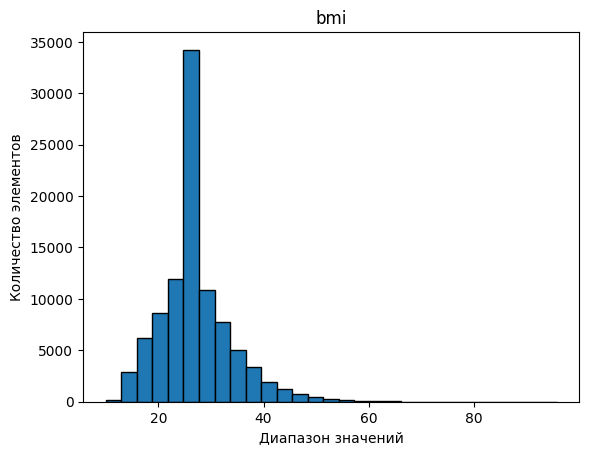

In [ ]:
k = 5

# Подсчёт элементов в каждом бакете
hist, bin_edges = np.histogram(X.iloc[:,k].values, bins = Gaus_neuron_hard(X, 30, 0.6)[1][k])

# Построение гистограммы
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor='black', align='edge')

# Настройка осей
plt.xlabel('Диапазон значений')
plt.ylabel('Количество элементов')
plt.title(f'{X.columns[k]}')

# Показать график
plt.show()

In [ ]:
# Разделение на обучающую и тестовую выборки
X_train_G_HARD, X_test_G_HARD, y_train, y_test = train_test_split(Final_df_HARD, y, test_size=0.2, random_state=42)

# Нормализация данных для Logistic Regression
scaler_G_HARD = StandardScaler()
X_train_scaled_G_HARD = scaler_G_HARD.fit_transform(X_train_G_HARD)
X_test_scaled_G_HARD = scaler_G_HARD.transform(X_test_G_HARD)

In [ ]:
Final_df_HARD.shape

(96128, 132)

In [ ]:
# 1. Random Forest
rf_model_G_HARD = RandomForestClassifier(random_state=42)
rf_cv_scores_G_HARD = cross_val_score(rf_model_G_HARD, Final_df_HARD, y, cv=5, scoring='accuracy')

print("Random Forest:")
print("Accuracy: {:.4f} ± {:.4f}".format(rf_cv_scores_G_HARD.mean(), rf_cv_scores_G_HARD.std()))

rf_model_G_HARD = RandomForestClassifier(random_state=42)
rf_model_G_HARD.fit(X_train_G_HARD, y_train)
y_pred_rf_G_HARD = rf_model_G_HARD.predict(X_test_G_HARD)
y_pred_rf_G_proba_HARD = rf_model_G_HARD.predict_proba(X_test_G_HARD)[:, 1]

print("Gini:", gini(y_test, y_pred_rf_G_proba_HARD))
# print("Accuracy:", accuracy_score(y_test, y_pred_rf_G_HARD))

Random Forest:
Accuracy: 0.9519 ± 0.0008
Gini: 0.8246129951249623


In [ ]:
# 2. Logistic Regression с нормализованными данными
logreg_model_G_HARD = LogisticRegression(max_iter=10000, random_state=42)
logreg_cv_scores_G_HARD = cross_val_score(logreg_model_G_HARD, scaler_G_HARD.fit_transform(Final_df_HARD), y, cv=5, scoring='accuracy')

print("Logistic Regression (with normalization):")
print("Accuracy: {:.4f} ± {:.4f}".format(logreg_cv_scores_G_HARD.mean(), logreg_cv_scores_G_HARD.std()))

logreg_model_G_HARD = LogisticRegression(max_iter=10000, random_state=42)
logreg_model_G_HARD.fit(X_train_scaled_G_HARD, y_train)
y_pred_logreg_G_HARD = logreg_model_G_HARD.predict(X_test_scaled_G_HARD)
y_pred_logreg_G_proba_HARD = logreg_model_G_HARD.predict_proba(X_test_scaled_G_HARD)[:, 1]

print("Gini:", gini(y_test, y_pred_logreg_G_proba_HARD))
# print("Accuracy:", accuracy_score(y_test, y_pred_logreg_G_HARD))

Logistic Regression (with normalization):
Accuracy: 0.9594 ± 0.0014
Gini: 0.8943816383917826


In [ ]:
# 3. CatBoost с улучшенными параметрами
catboost_model_G_HARD = CatBoostClassifier(
    iterations=2000,         # Увеличение количества итераций
    learning_rate=0.05,      # Уменьшение скорости обучения
    depth=8,                 # Увеличение глубины деревьев
    l2_leaf_reg=3,           # Регуляризация L2 для предотвращения переобучения
    bagging_temperature=1.0, # Использование bagging для улучшения обобщающей способности
    verbose=0,               # Отключение вывода
    random_seed=42
)
catboost_cv_scores_G_HARD = cross_val_score(catboost_model_G_HARD, Final_df_HARD, y, cv=5, scoring='accuracy')

print("CatBoost:")
print("Accuracy: {:.4f} ± {:.4f}".format(catboost_cv_scores_G_HARD.mean(), catboost_cv_scores_G_HARD.std()))

catboost_model_G_HARD = CatBoostClassifier(
    iterations=2000,         # Увеличение количества итераций
    learning_rate=0.05,      # Уменьшение скорости обучения
    depth=8,                 # Увеличение глубины деревьев
    l2_leaf_reg=3,           # Регуляризация L2 для предотвращения переобучения
    bagging_temperature=1.0, # Использование bagging для улучшения обобщающей способности
    verbose=0,               # Отключение вывода
    random_seed=42
)
catboost_model_G_HARD.fit(X_train_G_HARD, y_train)
y_pred_catboost_G_HARD = catboost_model_G_HARD.predict(X_test_G_HARD)
y_pred_catboost_G_proba_HARD = catboost_model_G_HARD.predict_proba(X_test_G_HARD)[:, 1]

print("Gini:", gini(y_test, y_pred_catboost_G_proba_HARD))
# print("Accuracy:", accuracy_score(y_test, y_pred_catboost_G_HARD))

CatBoost:
Accuracy: 0.9574 ± 0.0014
Gini: 0.884945349760693


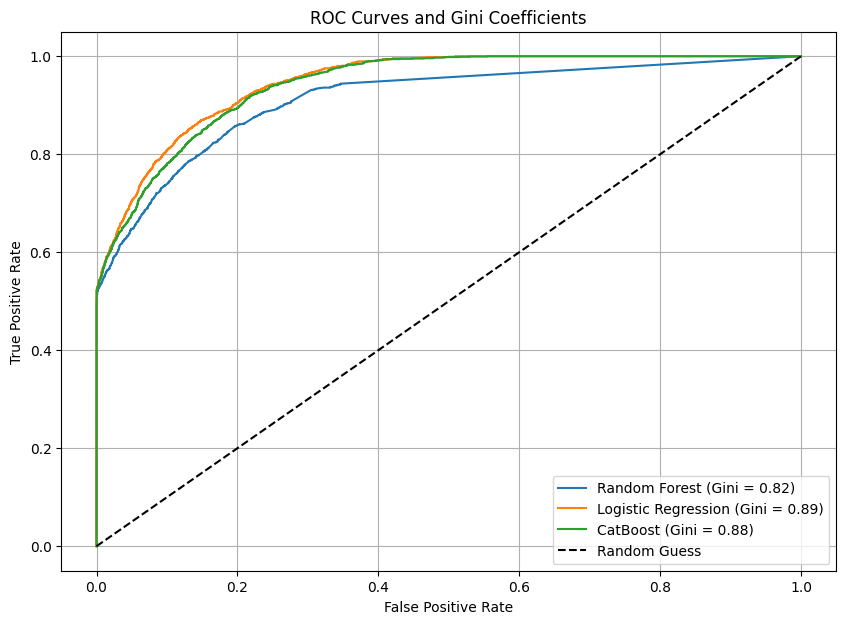

In [ ]:
# Визуализация ROC-кривых
plt.figure(figsize=(10, 7))

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_G_proba_HARD)
plt.plot(fpr_rf, tpr_rf, label="Random Forest (Gini = {:.2f})".format(gini(y_test, y_pred_rf_G_proba_HARD)))

# Logistic Regression
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_logreg_G_proba_HARD)
plt.plot(fpr_logreg, tpr_logreg, label="Logistic Regression (Gini = {:.2f})".format(gini(y_test, y_pred_logreg_G_proba_HARD)))

# CB
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_catboost_G_proba_HARD)
plt.plot(fpr_logreg, tpr_logreg, label="CatBoost (Gini = {:.2f})".format(gini(y_test, y_pred_catboost_G_proba_HARD)))

# Общие настройки графика
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves and Gini Coefficients")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# ADVANCE GAUSS ENCODING

def calculate_quantile_bounds(data, num_quantiles):

    data = np.asarray(data)
    quantile_bounds = np.quantile(data, q = np.linspace(0, 1, num_quantiles))# + 1

    return quantile_bounds

In [ ]:
def hard_transform(ci_ar, x_ar):

    N_ci = ci_ar.shape[0]
    test_init = np.digitize(x_ar, ci_ar, right = True).reshape(-1, 1)
    test = test_init.copy()

    pi_ar = np.ones((x_ar.shape[0], ci_ar.shape[0]))

    ind_min_x = np.unique(np.where(test_init == 0)[0])
    ind_max_x = np.unique(np.where(test_init == ci_ar.shape[0])[0])
    pi_ar[ind_min_x] = np.arange(ci_ar.shape[0])
    pi_ar[ind_max_x] = np.flip(np.arange(ci_ar.shape[0]))

    ind_oth = np.setdiff1d(np.arange(len(x_ar)), np.hstack((ind_min_x, ind_max_x)))

    right_b = ci_ar[test_init[ind_oth].flatten()]
    left_b = ci_ar[test_init[ind_oth].flatten() - 1]

    left_d = (x_ar[ind_oth] - left_b) / (right_b - left_b )
    right_d = (- x_ar[ind_oth] + right_b) / (right_b - left_b )

    pi_ar[ind_oth, test_init[ind_oth].flatten()] = right_d
    pi_ar[ind_oth, test_init[ind_oth].flatten() - 1] = left_d

    mask = pi_ar[ind_oth] != 1
    left_non_one = np.argmax(mask, axis=1)
    right_non_one = pi_ar[ind_oth].shape[1] - 1 - np.argmax(mask[:, ::-1], axis=1)

    for i, _idx in enumerate(ind_oth):
        csum_ = np.cumsum(pi_ar[_idx, right_non_one[i]:])
        pi_ar[_idx, right_non_one[i]:] = csum_

    for i, _idx in enumerate(ind_oth):
        csum_ = np.cumsum(pi_ar[_idx, :left_non_one[i]+1][::-1])[::-1]
        pi_ar[_idx, : left_non_one[i] + 1] = csum_

    return pi_ar

In [ ]:
def Gaus_neuron_hard_AD(df, n, S_):

    brdrs_ar = np.zeros((df.shape[1], n))

    for indx, col in enumerate(df.columns):

        vol = df[col].values
        min_ = np.min(vol)
        max_ = np.max(vol)

        if np.unique(vol).shape[0] < 10:

            array = vol.copy()
            unique_values = np.unique(vol)
            dummy_array = (array[:, None] == unique_values).astype(int)
            dummy_array = np.where(dummy_array == 1, 0, 100)
            hard_enc_G = dummy_array

        else:

            quantile_bounds = calculate_quantile_bounds(vol, n)
            brdrs_ar[indx, :] = quantile_bounds
            hard_enc_G = (hard_transform(quantile_bounds, vol)) ** 2 / (S_ ** 2)

        if indx == 0:
            hard_G_Total = hard_enc_G.copy()
        else:
            hard_G_Total = np.hstack((hard_G_Total, hard_enc_G))

    return hard_G_Total, brdrs_ar

In [ ]:
Final_df_HARD_AD = Gaus_neuron_hard_AD(X, 30, 0.6)[0]
Final_df_HARD_AD = np.exp(-Final_df_HARD_AD)
Final_df_HARD_AD = np.where(Final_df_HARD_AD < 0.01, 0, Final_df_HARD_AD)
Final_df_HARD_AD *= 10
Final_df_HARD_AD = np.round(Final_df_HARD_AD)
Final_df_HARD_AD = pd.DataFrame(Final_df_HARD_AD)
Final_df_HARD_AD

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96123,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96124,10.0,0.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96125,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96126,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


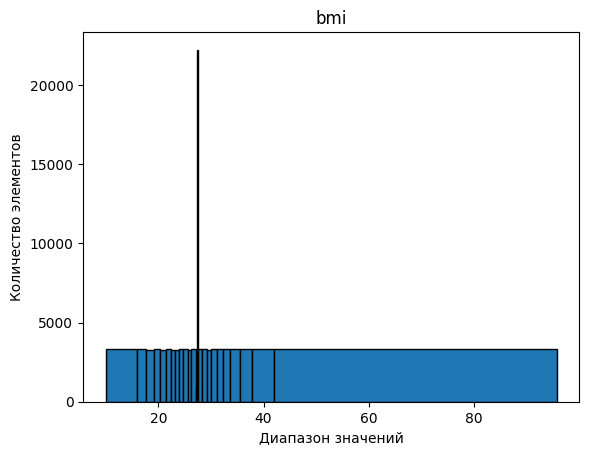

In [ ]:
k = 5

# Подсчёт элементов в каждом бакете
hist, bin_edges = np.histogram(X.iloc[:,k].values, bins = Gaus_neuron_hard_AD(X, 30, 0.6)[1][k])

# Построение гистограммы
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor='black', align='edge')

# Настройка осей
plt.xlabel('Диапазон значений')
plt.ylabel('Количество элементов')
plt.title(f'{X.columns[k]}')

# Показать график
plt.show()

In [ ]:
# Разделение на обучающую и тестовую выборки new
X_train_G_HARD_AD, X_test_G_HARD_AD = train_test_split(Final_df_HARD_AD, test_size=0.2, random_state=42)

# Нормализация данных для Logistic Regression
scaler_G_HARD_AD = StandardScaler()
X_train_scaled_G_HARD_AD = scaler_G_HARD_AD.fit_transform(X_train_G_HARD_AD)
X_test_scaled_G_HARD_AD = scaler_G_HARD_AD.transform(X_test_G_HARD_AD)

In [ ]:
# 1. Random Forest
rf_model_G_HARD_AD = RandomForestClassifier(random_state=42)
rf_cv_scores_G_HARD_AD = cross_val_score(rf_model_G_HARD_AD, Final_df_HARD_AD, y, cv=5, scoring='accuracy')

print("Random Forest:")
print("Accuracy: {:.4f} ± {:.4f}".format(rf_cv_scores_G_HARD_AD.mean(), rf_cv_scores_G_HARD_AD.std()))

rf_model_G_HARD_AD = RandomForestClassifier(random_state=42)
rf_model_G_HARD_AD.fit(X_train_G_HARD_AD, y_train)
y_pred_rf_G_HARD_AD = rf_model_G_HARD_AD.predict(X_test_G_HARD_AD)
y_pred_rf_G_proba_HARD_AD = rf_model_G_HARD_AD.predict_proba(X_test_G_HARD_AD)[:, 1]

print("Gini:", gini(y_test, y_pred_rf_G_proba_HARD_AD))
# print("Accuracy:", accuracy_score(y_test, y_pred_rf_G_HARD_AD))

Random Forest:
Accuracy: 0.9694 ± 0.0010
Gini: 0.9243154609900528


In [ ]:
# 2. Logistic Regression с нормализованными данными
logreg_model_G_HARD_AD = LogisticRegression(max_iter=10000, random_state=42)
logreg_cv_scores_G_HARD_AD = cross_val_score(logreg_model_G_HARD_AD, scaler.fit_transform(Final_df_HARD_AD), y, cv=5, scoring='accuracy')

print("Logistic Regression (with normalization):")
print("Accuracy: {:.4f} ± {:.4f}".format(logreg_cv_scores_G_HARD_AD.mean(), logreg_cv_scores_G_HARD_AD.std()))

logreg_model_G_HARD_AD = LogisticRegression(max_iter=10000, random_state=42)
logreg_model_G_HARD_AD.fit(X_train_scaled_G_HARD_AD, y_train)
y_pred_logreg_G_HARD_AD = logreg_model_G_HARD_AD.predict(X_test_scaled_G_HARD_AD)
y_pred_logreg_G_proba_HARD_AD = logreg_model_G_HARD_AD.predict_proba(X_test_scaled_G_HARD_AD)[:, 1]

print("Gini:", gini(y_test, y_pred_logreg_G_proba_HARD_AD))
# print("Accuracy:", accuracy_score(y_test, y_pred_logreg_G_HARD_AD))

Logistic Regression (with normalization):
Accuracy: 0.9709 ± 0.0010
Gini: 0.95573086570709


In [ ]:
# 3. CatBoost с улучшенными параметрами
catboost_model_G_HARD_AD = CatBoostClassifier(
    iterations=2000,         # Увеличение количества итераций
    learning_rate=0.05,      # Уменьшение скорости обучения
    depth=8,                 # Увеличение глубины деревьев
    l2_leaf_reg=3,           # Регуляризация L2 для предотвращения переобучения
    bagging_temperature=1.0, # Использование bagging для улучшения обобщающей способности
    verbose=0,               # Отключение вывода
    random_seed=42
)
catboost_cv_scores_G_HARD_AD = cross_val_score(catboost_model_G_HARD_AD, Final_df_HARD_AD, y, cv=5, scoring='accuracy')

print("CatBoost:")
print("Accuracy: {:.4f} ± {:.4f}".format(catboost_cv_scores_G_HARD_AD.mean(), catboost_cv_scores_G_HARD_AD.std()))

catboost_model_G_HARD_AD = CatBoostClassifier(
    iterations=2000,         # Увеличение количества итераций
    learning_rate=0.05,      # Уменьшение скорости обучения
    depth=8,                 # Увеличение глубины деревьев
    l2_leaf_reg=3,           # Регуляризация L2 для предотвращения переобучения
    bagging_temperature=1.0, # Использование bagging для улучшения обобщающей способности
    verbose=0,               # Отключение вывода
    random_seed=42
)
catboost_model_G_HARD_AD.fit(X_train_G_HARD_AD, y_train)
y_pred_catboost_G_HARD_AD = catboost_model_G_HARD_AD.predict(X_test_G_HARD_AD)
y_pred_catboost_G_proba_HARD_AD = catboost_model_G_HARD_AD.predict_proba(X_test_G_HARD_AD)[:, 1]

print("Gini:", gini(y_test, y_pred_catboost_G_proba_HARD_AD))
# print("Accuracy:", accuracy_score(y_test, y_pred_catboost_G_HARD_AD))

CatBoost:
Accuracy: 0.9696 ± 0.0011
Gini: 0.9456763286847296


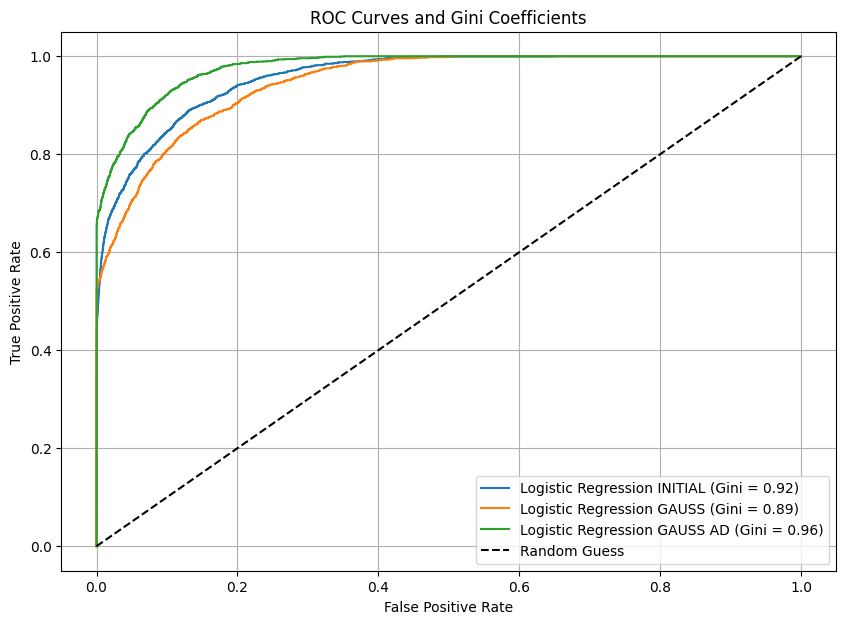

In [ ]:
# Визуализация ROC-кривых
plt.figure(figsize=(10, 7))

# Logistic Regression
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_logreg_proba)
plt.plot(fpr_logreg, tpr_logreg, label="Logistic Regression INITIAL (Gini = {:.2f})".format(gini(y_test, y_pred_logreg_proba)))

# Logistic Regression
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_logreg_G_proba_HARD)
plt.plot(fpr_logreg, tpr_logreg, label="Logistic Regression GAUSS (Gini = {:.2f})".format(gini(y_test, y_pred_logreg_G_proba_HARD)))

# Logistic Regression
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_logreg_G_proba_HARD_AD)
plt.plot(fpr_logreg, tpr_logreg, label="Logistic Regression GAUSS AD (Gini = {:.2f})".format(gini(y_test, y_pred_logreg_G_proba_HARD_AD)))

# Общие настройки графика
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves and Gini Coefficients")
plt.legend()
plt.grid()
plt.show()

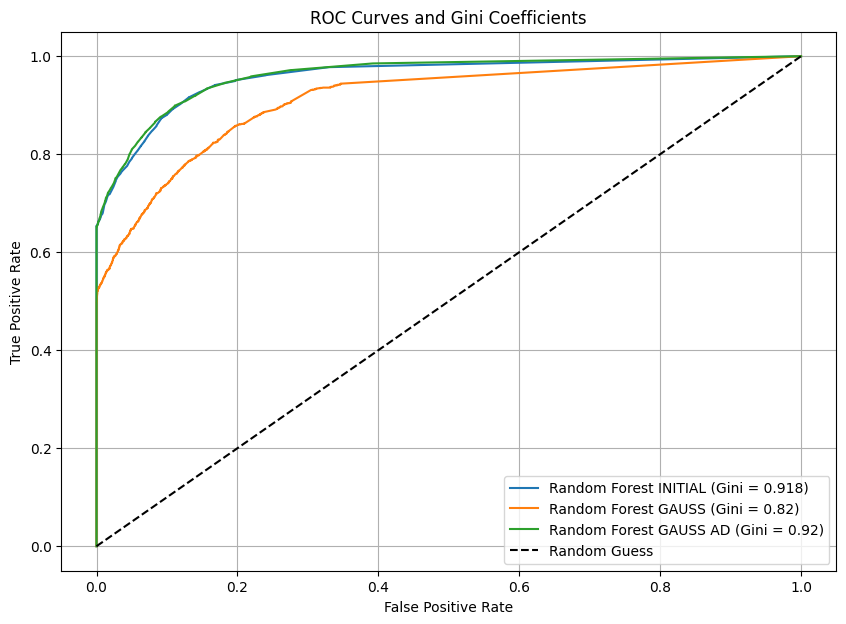

In [ ]:
# Визуализация ROC-кривых
plt.figure(figsize=(10, 7))

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_proba)
plt.plot(fpr_rf, tpr_rf, label="Random Forest INITIAL (Gini = {:.3f})".format(gini(y_test, y_pred_rf_proba)))

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_G_proba_HARD)
plt.plot(fpr_rf, tpr_rf, label="Random Forest GAUSS (Gini = {:.2f})".format(gini(y_test, y_pred_rf_G_proba_HARD)))

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_G_proba_HARD_AD)
plt.plot(fpr_rf, tpr_rf, label="Random Forest GAUSS AD (Gini = {:.2f})".format(gini(y_test, y_pred_rf_G_proba_HARD_AD)))

# Общие настройки графика
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves and Gini Coefficients")
plt.legend()
plt.grid()
plt.show()

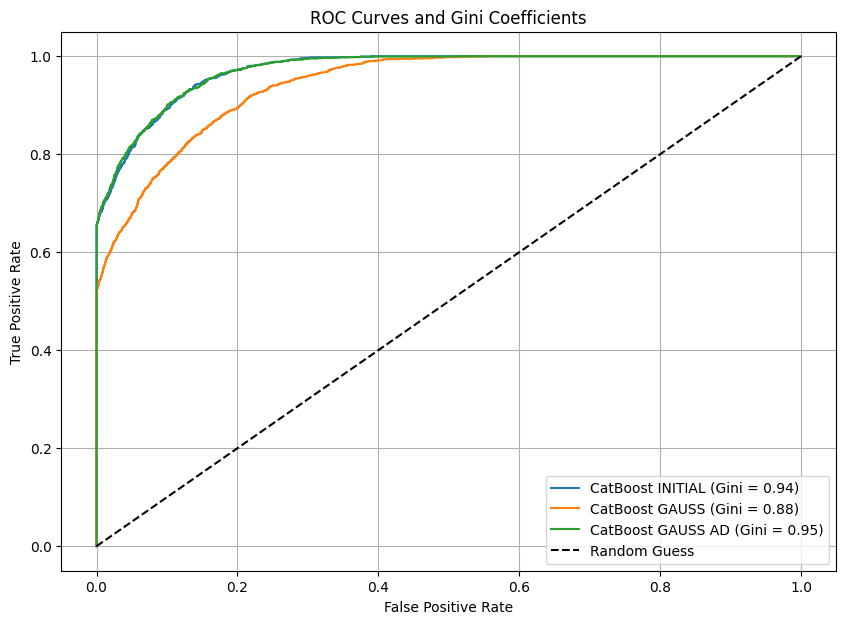

In [ ]:
# Визуализация ROC-кривых
plt.figure(figsize=(10, 7))

# cb
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_catboost_proba)
plt.plot(fpr_logreg, tpr_logreg, label="CatBoost INITIAL (Gini = {:.2f})".format(gini(y_test, y_pred_catboost_proba)))

# cb
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_catboost_G_proba_HARD)
plt.plot(fpr_logreg, tpr_logreg, label="CatBoost GAUSS (Gini = {:.2f})".format(gini(y_test, y_pred_catboost_G_proba_HARD)))

# cb
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_catboost_G_proba_HARD_AD)
plt.plot(fpr_logreg, tpr_logreg, label="CatBoost GAUSS AD (Gini = {:.2f})".format(gini(y_test, y_pred_catboost_G_proba_HARD_AD)))

# Общие настройки графика
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves and Gini Coefficients")
plt.legend()
plt.grid()
plt.show()

In [ ]:
y.sum()#X.shape#

8482